In [1]:
from utils.binaries import *
from utils.plotting import *
from utils.auger.sd.histo import SdHisto
from utils.auger.sd.moni import Monit

23:09:03 (  +12.9s) [INFO   ] -- import logging
23:09:03 (   +63ms) [INFO   ] -- import numpy as np
23:09:03 (    +6ms) [INFO   ] -- import uncertainties
23:09:03 (  +153ms) [INFO   ] -- import pandas as pd
23:09:03 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
23:09:03 (    +1ms) [INFO   ] -- import binaries.tools as tools
23:09:03 (  +233ms) [INFO   ] -- import matplotlib.pyplot as plt
23:09:04 (  +286ms) [INFO   ] -- import seaborn as so
23:09:04 (    +2ms) [INFO   ] -- set MONI_PATH = PosixPath('/home/filip/Data/monit_and_sd')
23:09:04 (    +0ms) [INFO   ] -- set HIST_PATH = PosixPath('/home/filip/Data/monit_and_sd')
23:09:04 (    +1ms) [INFO   ] -- set PLOT_PATH = PosixPath('/home/filip/Data/plots')
23:09:04 (    +0ms) [INFO   ] -- set DATA_PATH = PosixPath('/home/filip/Data')
23:09:04 (    +1ms) [INFO   ] -- set SCAN_PATH = PosixPath('/home/filip/Public/xy-calibration')
23:09:04 (    +1ms) [INFO   ] -- set OFLN_PATH = PosixPath('/home/filip/Public/offline/in

In [3]:
def do_shit(t3_events: str, monit: Monit) -> plt.Figure:
    # offline calib
    histos = np.loadtxt(t3_events)
    histos = np.split(histos, len(histos)//4)

    peak_times = {
            943: [],
            944: [],
            949: [],
            954: [],
            }

    peak_values = {
            943: [],
            944: [],
            949: [],
            954: [],
            }

    for i, histo in enumerate(histos):
        station_id = int(histo[:, 0][0])
        daq_time   = histo[:, 1][0]
        timestamp  = int(histo[:, 2][0])
        tube_mask  = histo[:, 3][0]
        iPMT = histo[:, 4]

        if station_id in [945, 972, 948]: continue

        PeakHisto = SdHisto(peak=histo[:, 5:], pmt_mask=[0,0,0,1])
        peak_charge = PeakHisto()
        
        peak_values[station_id].append(peak_charge['peak'][-1])
        peak_times[station_id].append(timestamp)

    # monit and plotting results
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    fig, axes = plt.subplots(4, 1, sharex=True)
    colors = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for station in [943, 944, 949, 954]:
        
        c = next(colors)

        time = monit('fTime', station)
        mip = monit('fPeak', station)[:, -1]

        ax1.plot(plot.to_datetime(time), mip, marker='none', label=station, c=c)
    #     ax2.plot(time, rate[:, -1], marker='none', c=c)                   # rate information

        ax1.errorbar(plot.to_datetime(peak_times[station]), [x.n for x in peak_values[station]], 
                    yerr=[x.std_dev for x in peak_values[station]],
                    ls='none', fmt='o', markersize=1, c=c, lw=0.1)
        # ax2.plot(time[15:-14], np.convolve(rate[:, -1], np.ones(30)/30, mode='valid') , marker='none')
        
        min_index = [np.argmin(np.abs(t - time)) for t in peak_times[station]]
        histo_mip = np.array([x.n for x in peak_values[station]])
        diff = (mip[min_index] - histo_mip) / histo_mip

        # 1000s between events w/ running mean over 86 events = 23.89 hours
        # ax2.plot(to_dt(time[min_index])[43:-42], 
        #          np.convolve(diff, np.ones(86)/86, mode='valid'), 
        #          color=c, label=f"{_id}: {np.nanmean(diff)*100:+.1f}%", 
        #          marker='none')

        _sort = np.argsort(min_index)
        ax2.plot(plot.to_datetime(time[min_index][_sort]), diff[_sort], label=f"{station}: {np.nanmean(diff)*100:+.1f}%", marker='none', c=c)

        try:
            rate = monit('f70HzRate', station)

            for i in range(4):
                axes[i].hist(rate[:, i], histtype='step')
        except IndexError: continue

    ax1.legend(ncol=2)
    ax2.legend(ncol=2)
        

(0) ALL FILES BELOW
(1) mc_2025_02_11_17h32.root
(2) mc_2025_02_11_00h01.root

(0) ALL FILES BELOW
(1) mc_2025_02_13_00h01.root
(2) mc_2025_02_13_17h14.root
(3) mc_2025_02_13_18h18.root
(4) mc_2025_02_13_14h08.root



23:09:20 (  +16.0s) [INFO   ] -- received 3 file(s) as input
23:09:20 (  +169ms) [INFO   ] -- View monit keys with self.keys()
23:09:21 (   +1.3s) [INFO   ] -- found 399 entries for key fTime and station #943
23:09:21 (   +10ms) [INFO   ] -- found 399 entries for key fPeak and station #943
23:09:21 (   +27ms) [INFO   ] -- found 399 entries for key f70HzRate and station #943
23:09:21 (   +15ms) [INFO   ] -- found 399 entries for key fTime and station #944
23:09:21 (    +7ms) [INFO   ] -- found 399 entries for key fPeak and station #944
23:09:21 (   +24ms) [INFO   ] -- found 399 entries for key f70HzRate and station #944
23:09:21 (   +15ms) [INFO   ] -- found 397 entries for key fTime and station #949
23:09:21 (    +8ms) [INFO   ] -- found 397 entries for key fPeak and station #949
23:09:21 (   +22ms) [INFO   ] -- found 397 entries for key f70HzRate and station #949
23:09:21 (   +15ms) [INFO   ] -- found 399 entries for key fTime and station #954
23:09:21 (    +7ms) [INFO   ] -- found 39

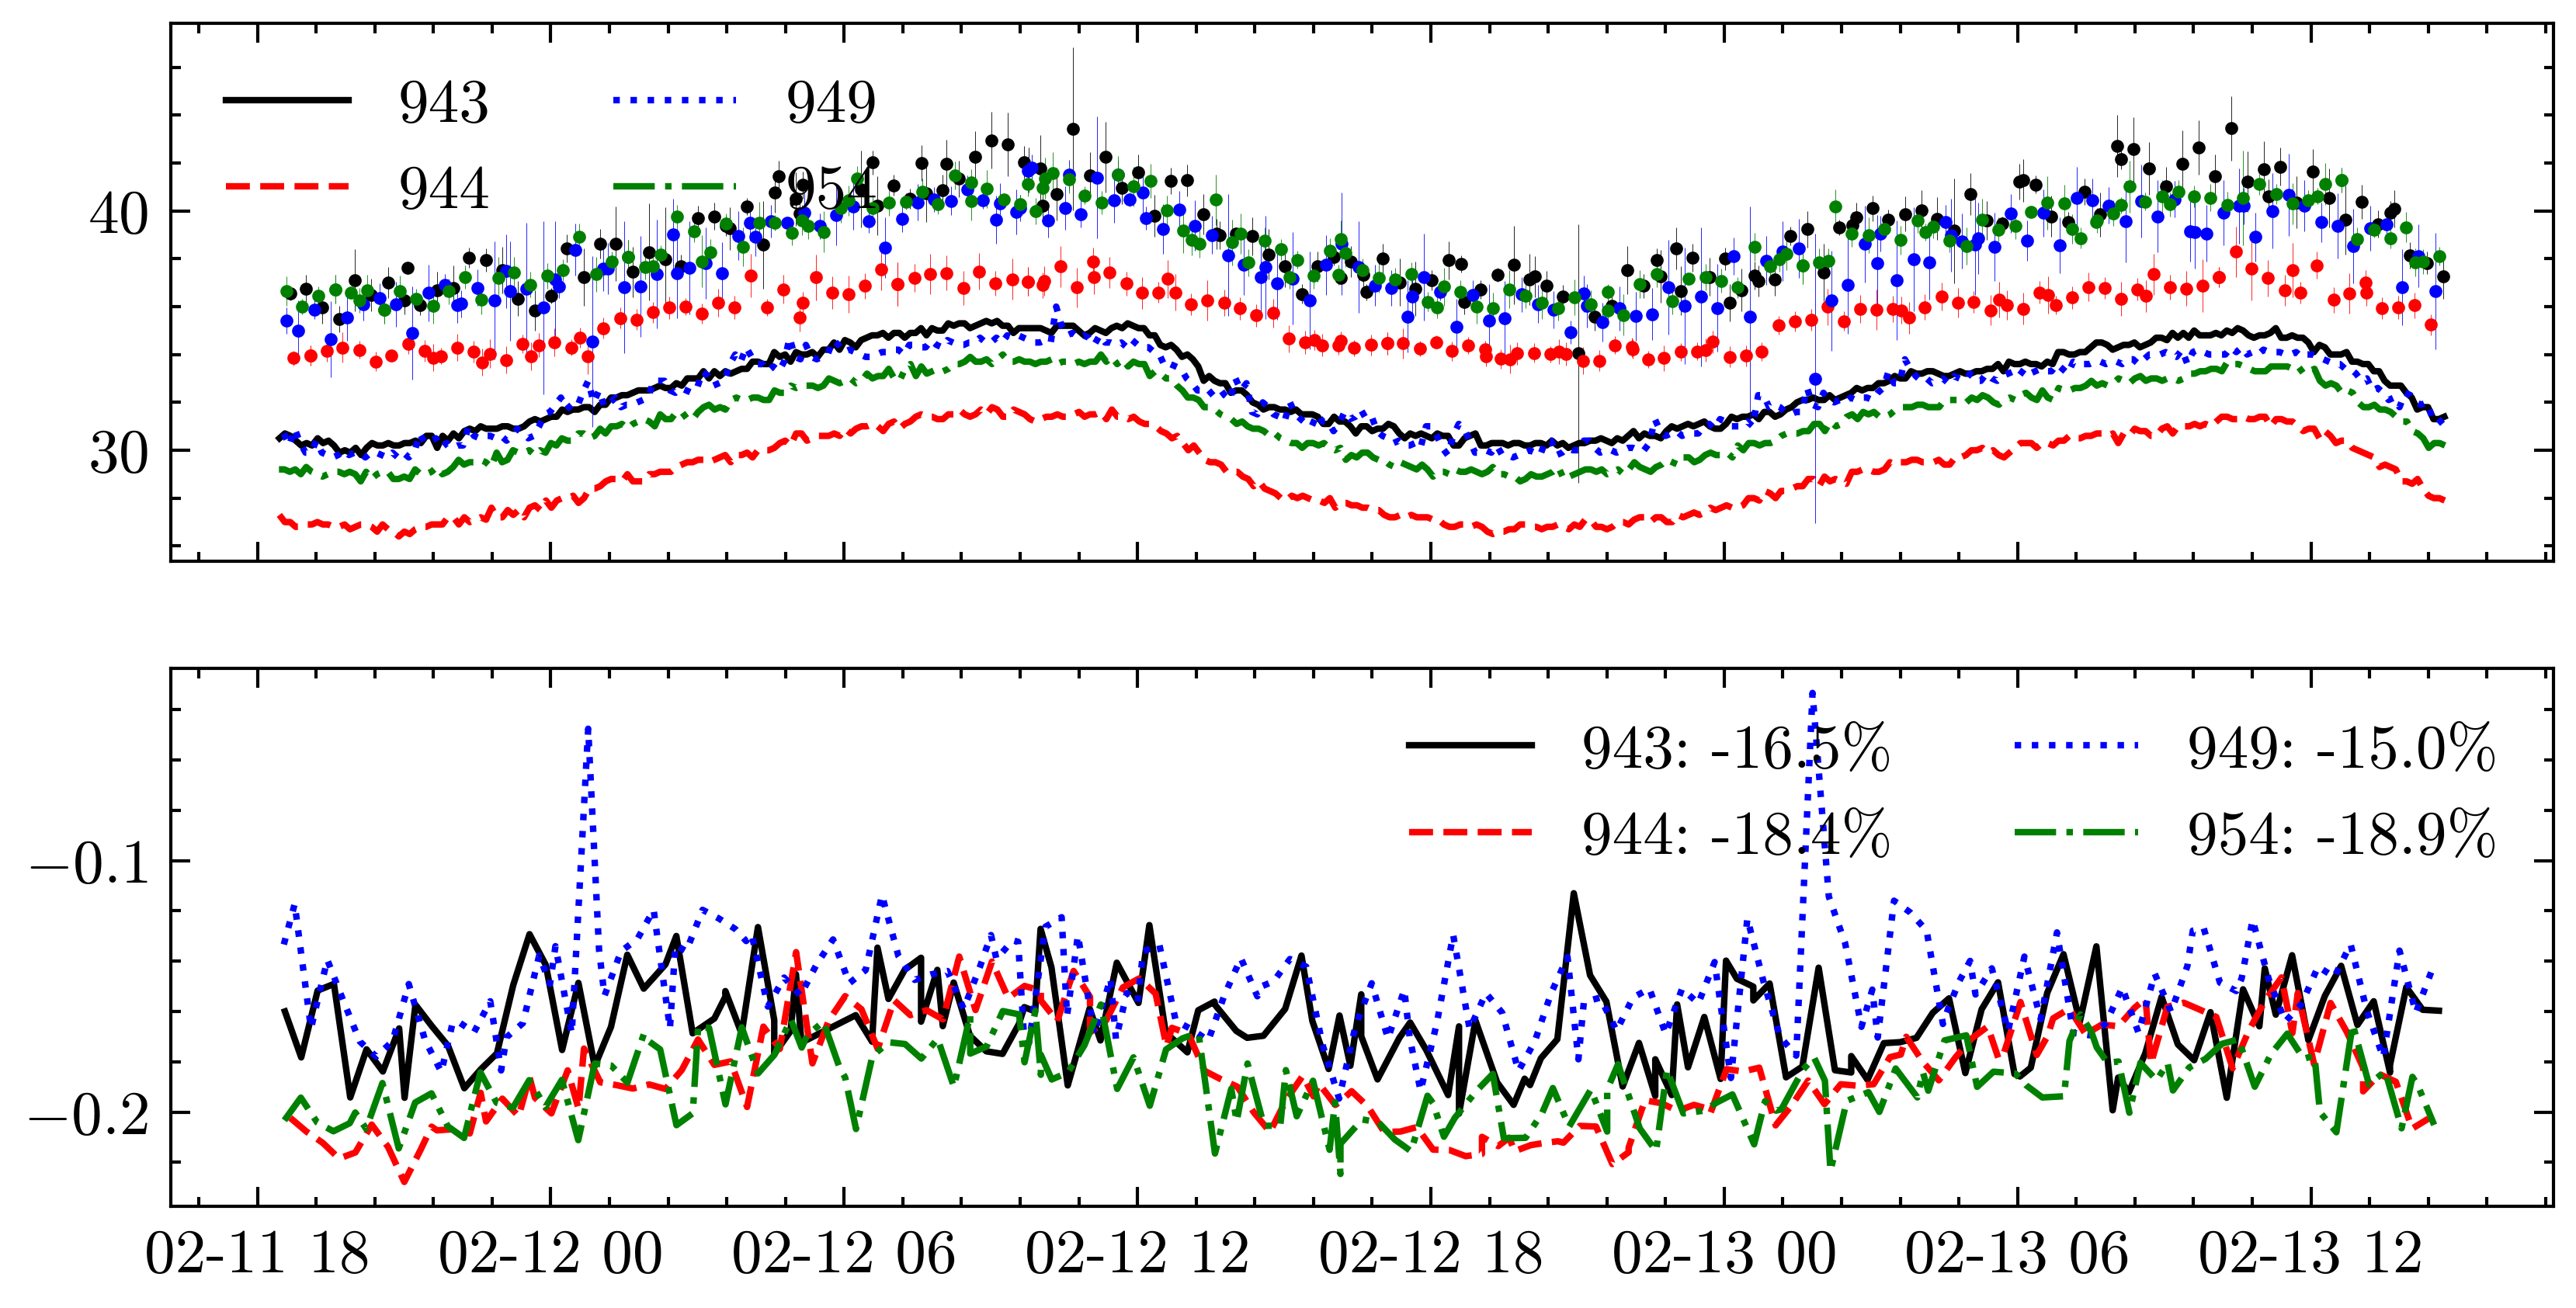

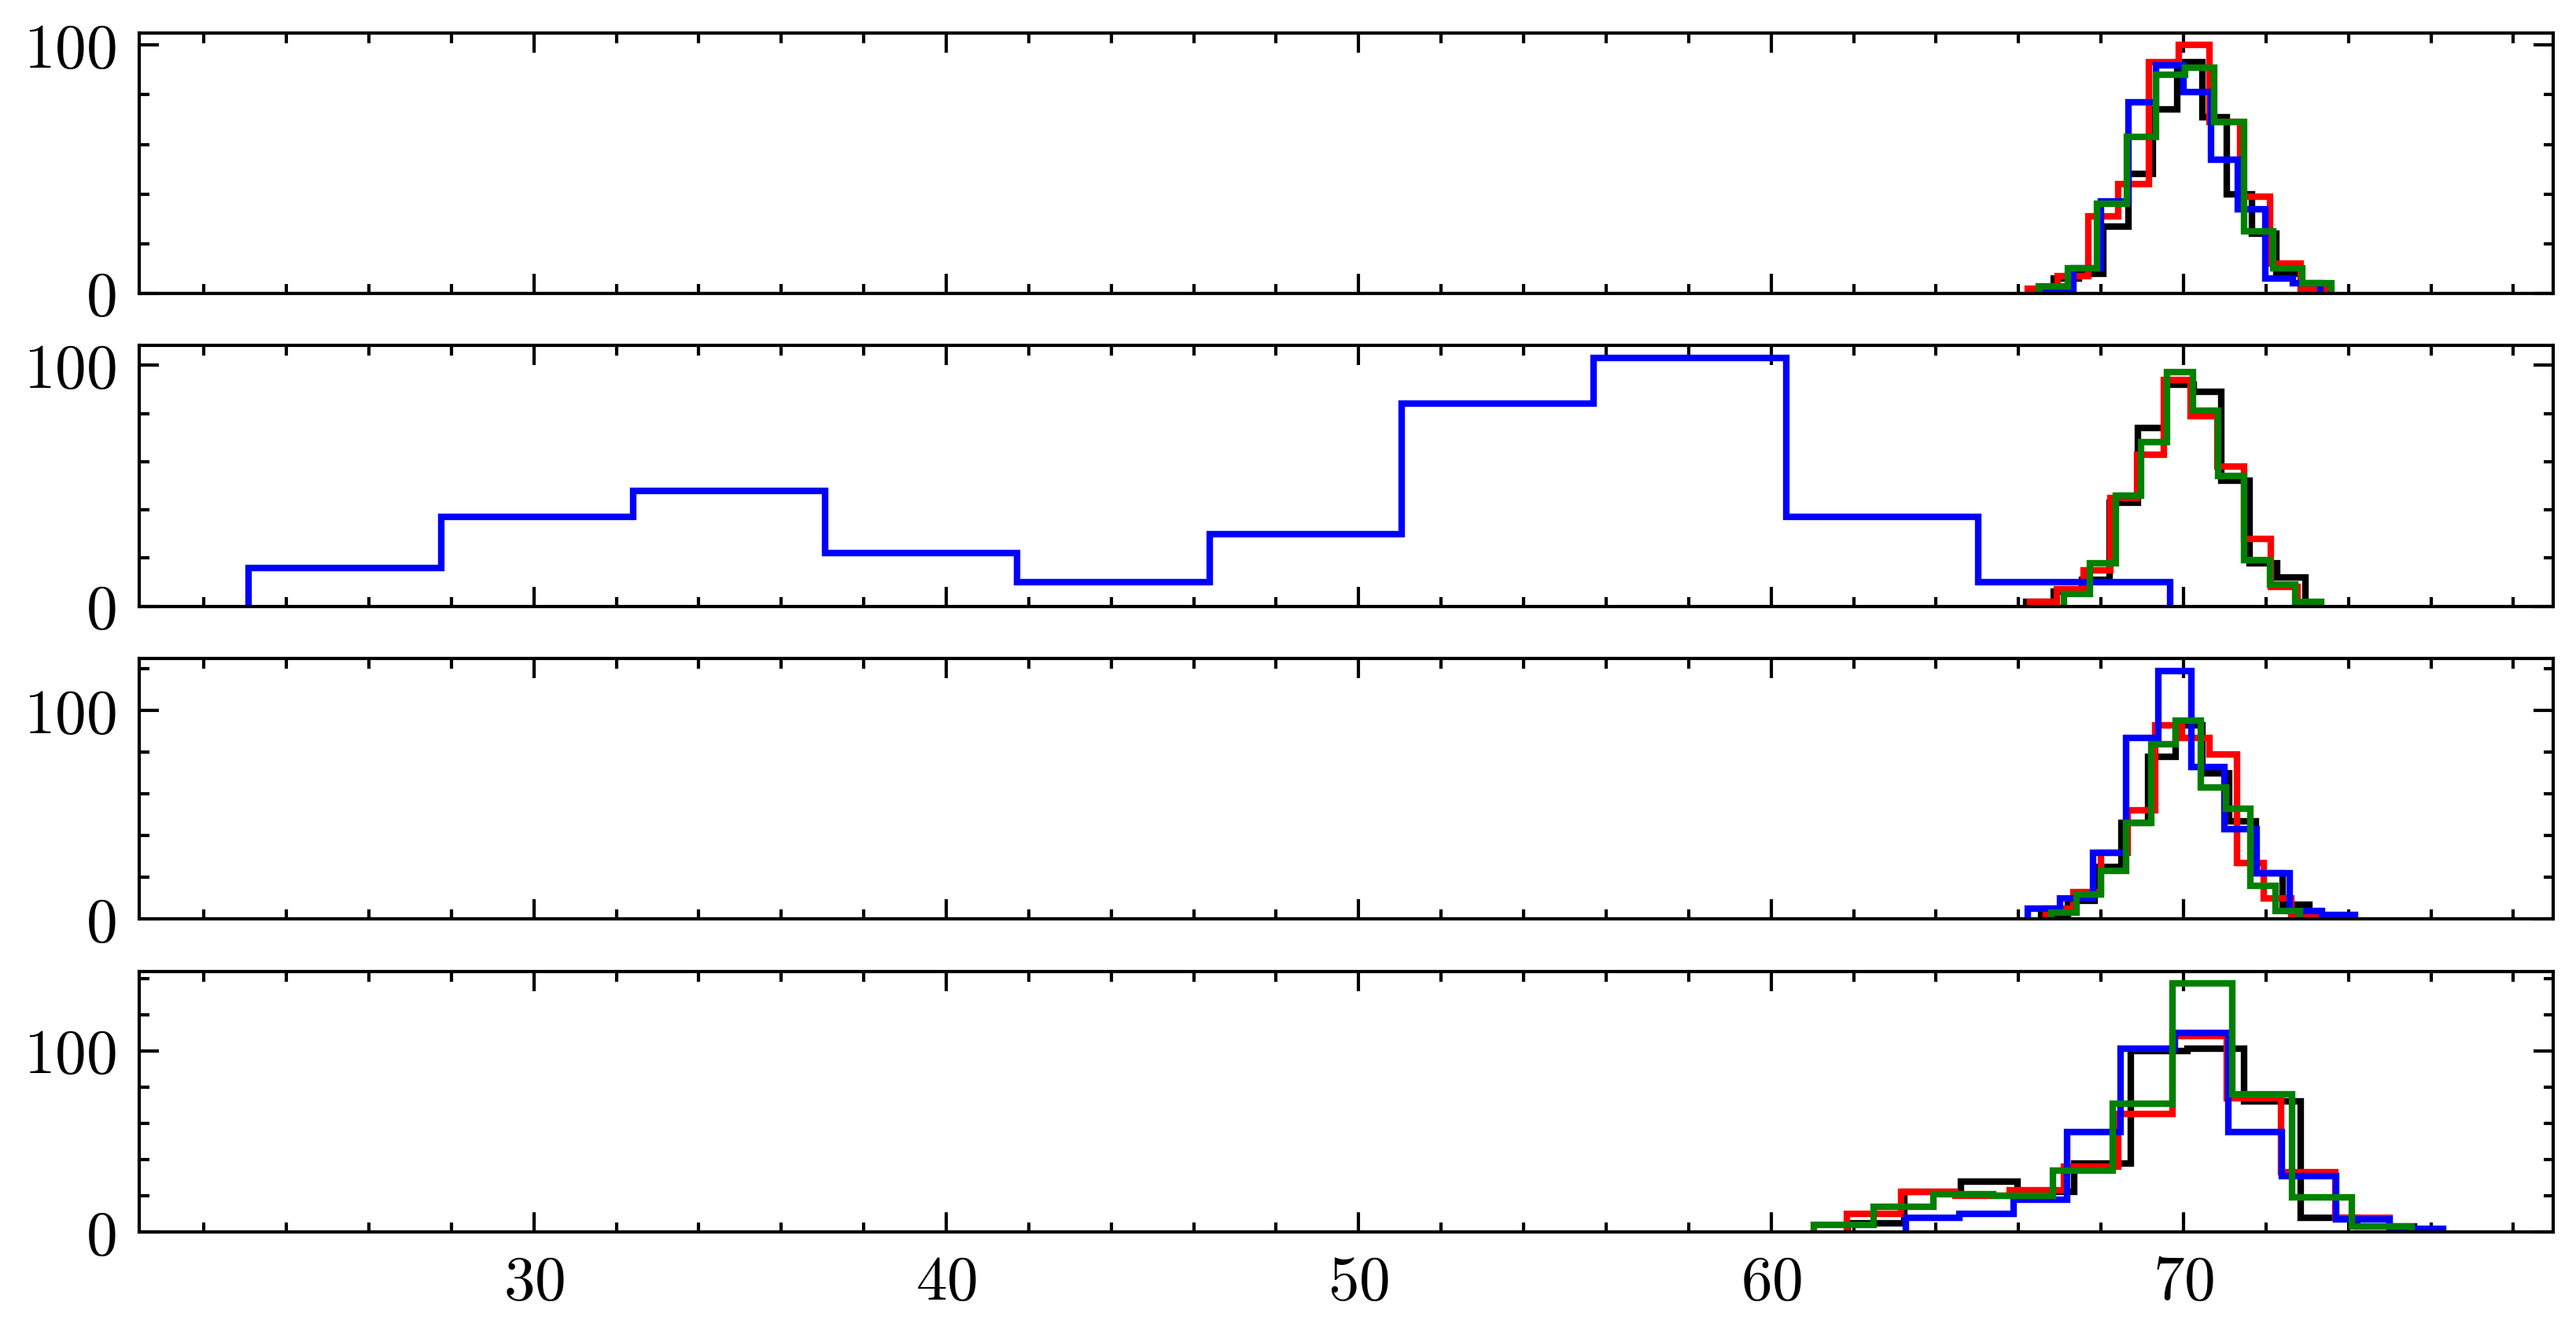

In [4]:
# 70 Hz Rate - 2.64 scaling factor
do_shit('peak1.txt', Monit(2025, 2, range(11,14)))

(0) ALL FILES BELOW
(1) mc_2025_02_13_00h01.root
(2) mc_2025_02_13_17h14.root
(3) mc_2025_02_13_18h18.root
(4) mc_2025_02_13_14h08.root



23:09:38 (  +16.5s) [INFO   ] -- received 5 file(s) as input
23:09:38 (  +331ms) [INFO   ] -- View monit keys with self.keys()
23:09:40 (   +2.2s) [INFO   ] -- found 804 entries for key fTime and station #943
23:09:40 (   +16ms) [INFO   ] -- found 804 entries for key fPeak and station #943


SSD SdHisto fit failed: large fit error for SSD: 126%


23:09:40 (   +44ms) [INFO   ] -- found 804 entries for key f70HzRate and station #943
23:09:40 (   +23ms) [INFO   ] -- found 805 entries for key fTime and station #944
23:09:40 (  +107ms) [INFO   ] -- found 805 entries for key fPeak and station #944
23:09:40 (   +39ms) [INFO   ] -- found 805 entries for key f70HzRate and station #944
23:09:40 (   +25ms) [INFO   ] -- found 805 entries for key fTime and station #949
23:09:41 (   +11ms) [INFO   ] -- found 805 entries for key fPeak and station #949
23:09:41 (   +43ms) [INFO   ] -- found 805 entries for key f70HzRate and station #949
23:09:41 (   +26ms) [INFO   ] -- found 801 entries for key fTime and station #954
23:09:41 (   +12ms) [INFO   ] -- found 801 entries for key fPeak and station #954
23:09:41 (   +43ms) [INFO   ] -- found 801 entries for key f70HzRate and station #954


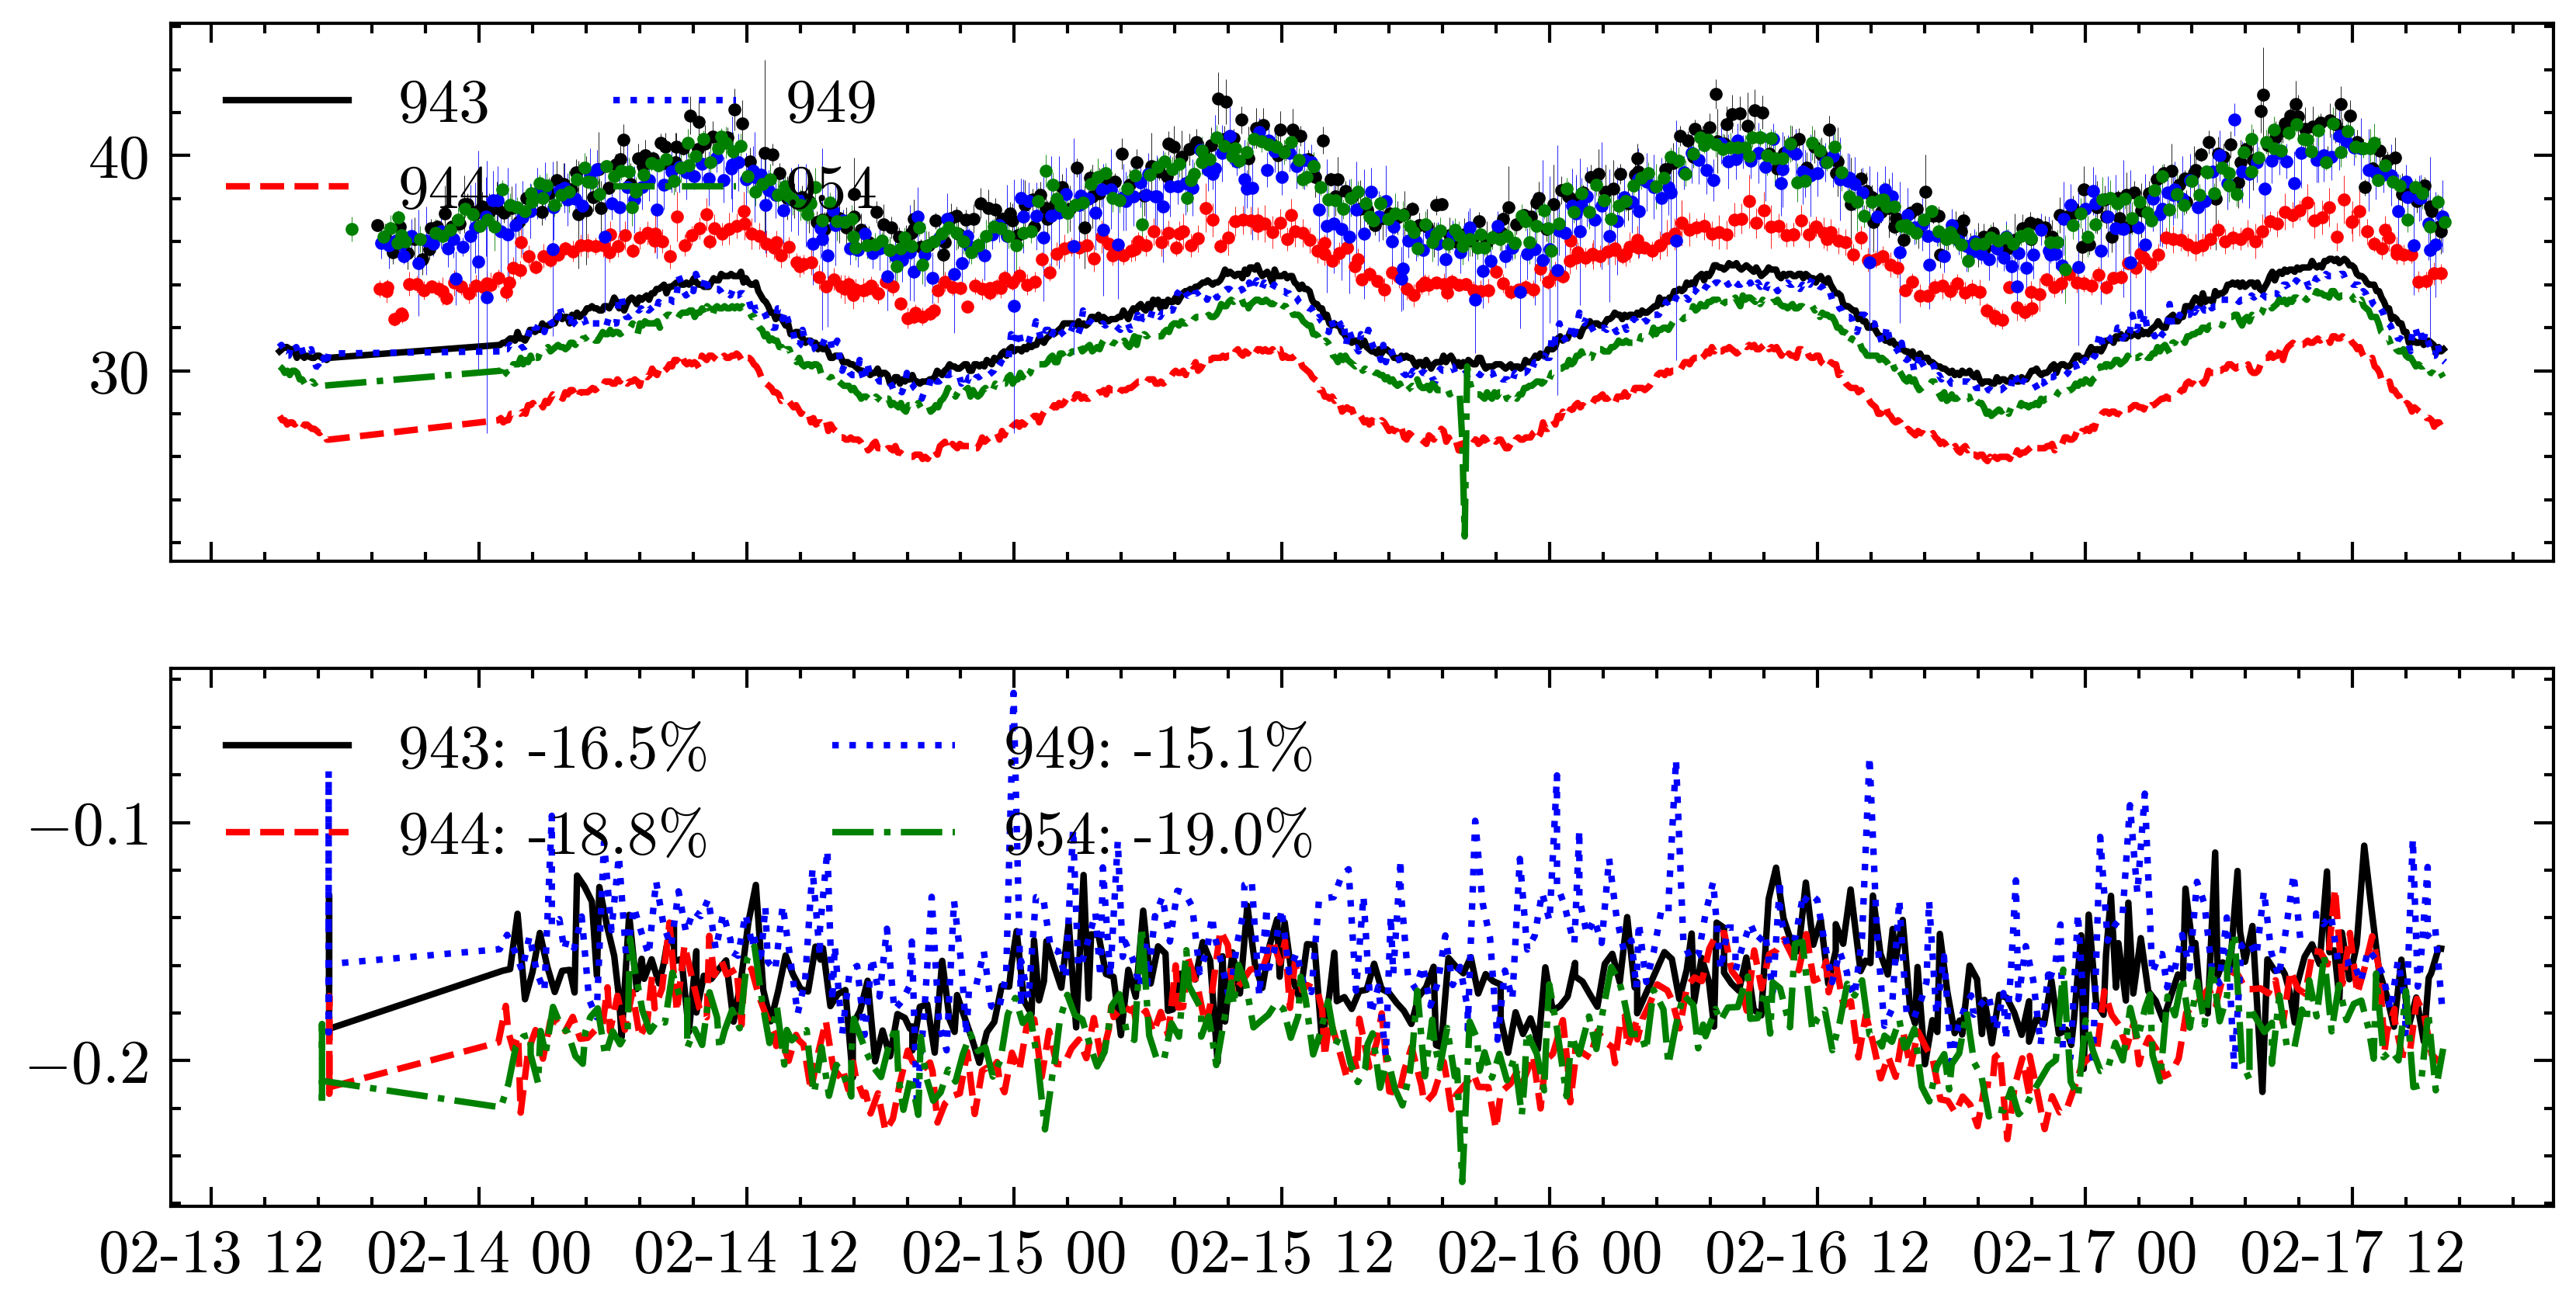

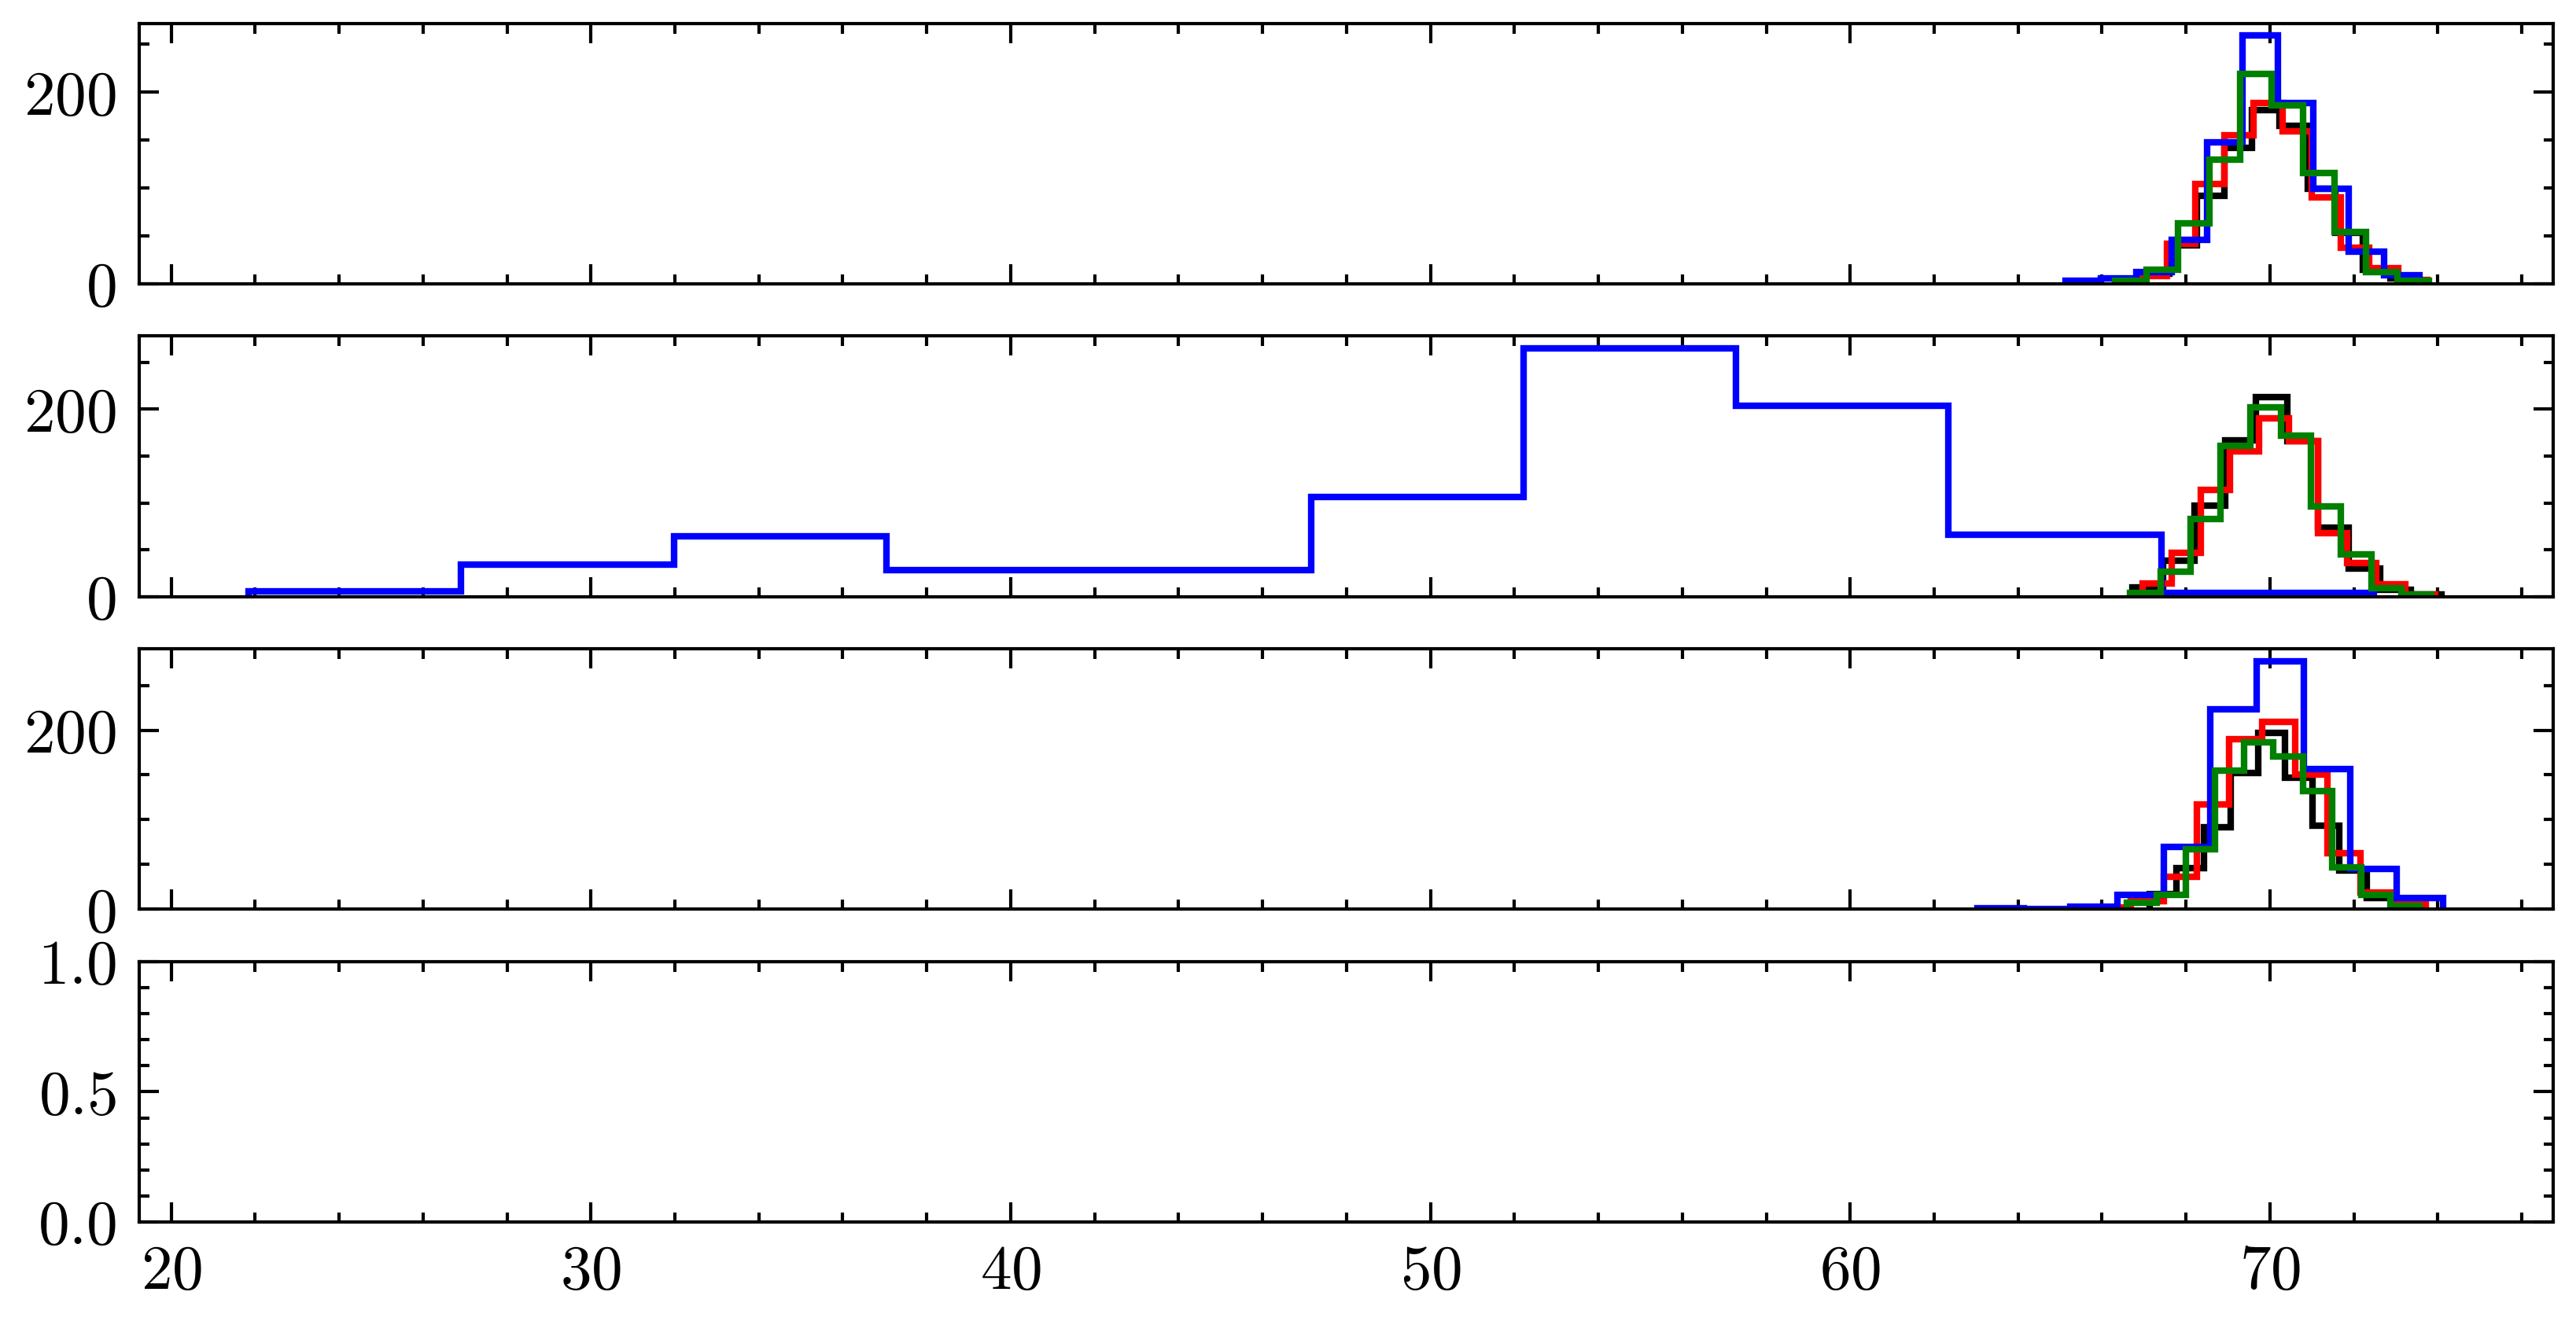

In [5]:
# 10 Hz Rate - 5.36 scaling factor
do_shit('peak2.txt', Monit(2025, 2, range(13,18)))

01:34:05 (+8664.0s) [INFO   ] -- received 3 file(s) as input
01:34:05 (  +165ms) [INFO   ] -- View monit keys with self.keys()
01:34:07 (   +2.1s) [INFO   ] -- found 513 entries for key fTime and station #943
01:34:07 (    +9ms) [INFO   ] -- found 513 entries for key fPeak and station #943
01:34:07 (   +30ms) [INFO   ] -- found 513 entries for key f70HzRate and station #943
01:34:07 (   +19ms) [INFO   ] -- found 509 entries for key fTime and station #944
01:34:07 (    +8ms) [INFO   ] -- found 509 entries for key fPeak and station #944
01:34:07 (   +32ms) [INFO   ] -- found 509 entries for key f70HzRate and station #944
01:34:07 (   +18ms) [INFO   ] -- found 514 entries for key fTime and station #949
01:34:07 (    +8ms) [INFO   ] -- found 514 entries for key fPeak and station #949
01:34:07 (   +33ms) [INFO   ] -- found 514 entries for key f70HzRate and station #949
01:34:07 (   +25ms) [INFO   ] -- found 513 entries for key fTime and station #954
01:34:07 (    +9ms) [INFO   ] -- found 51

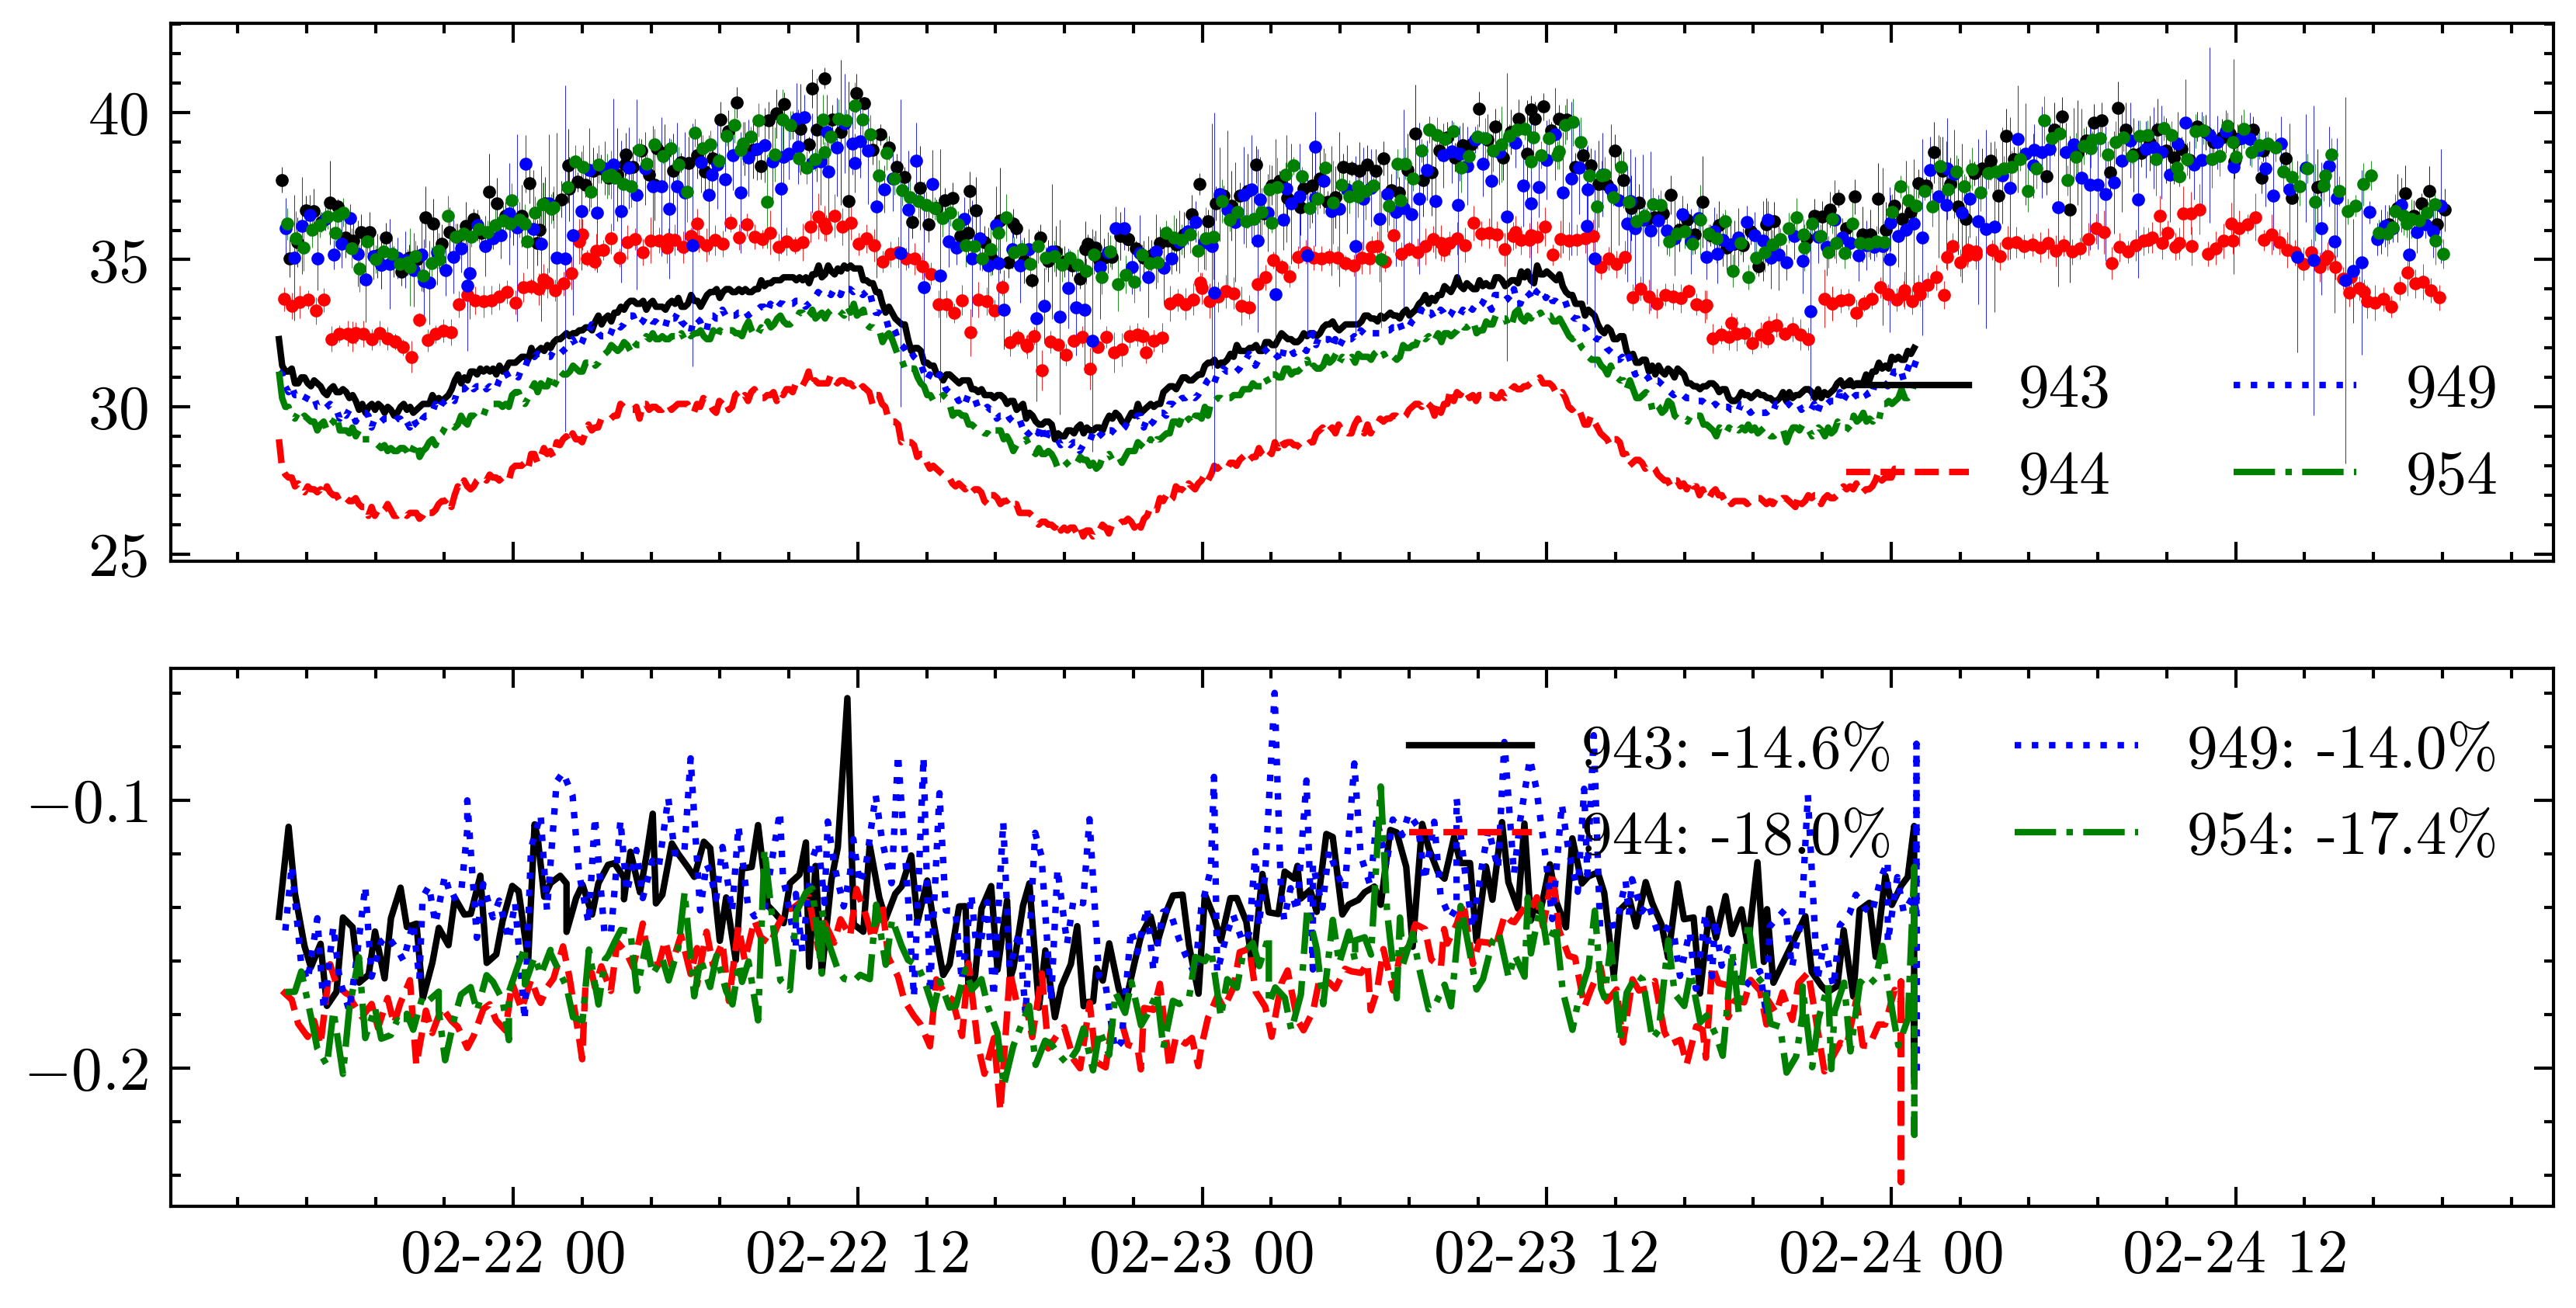

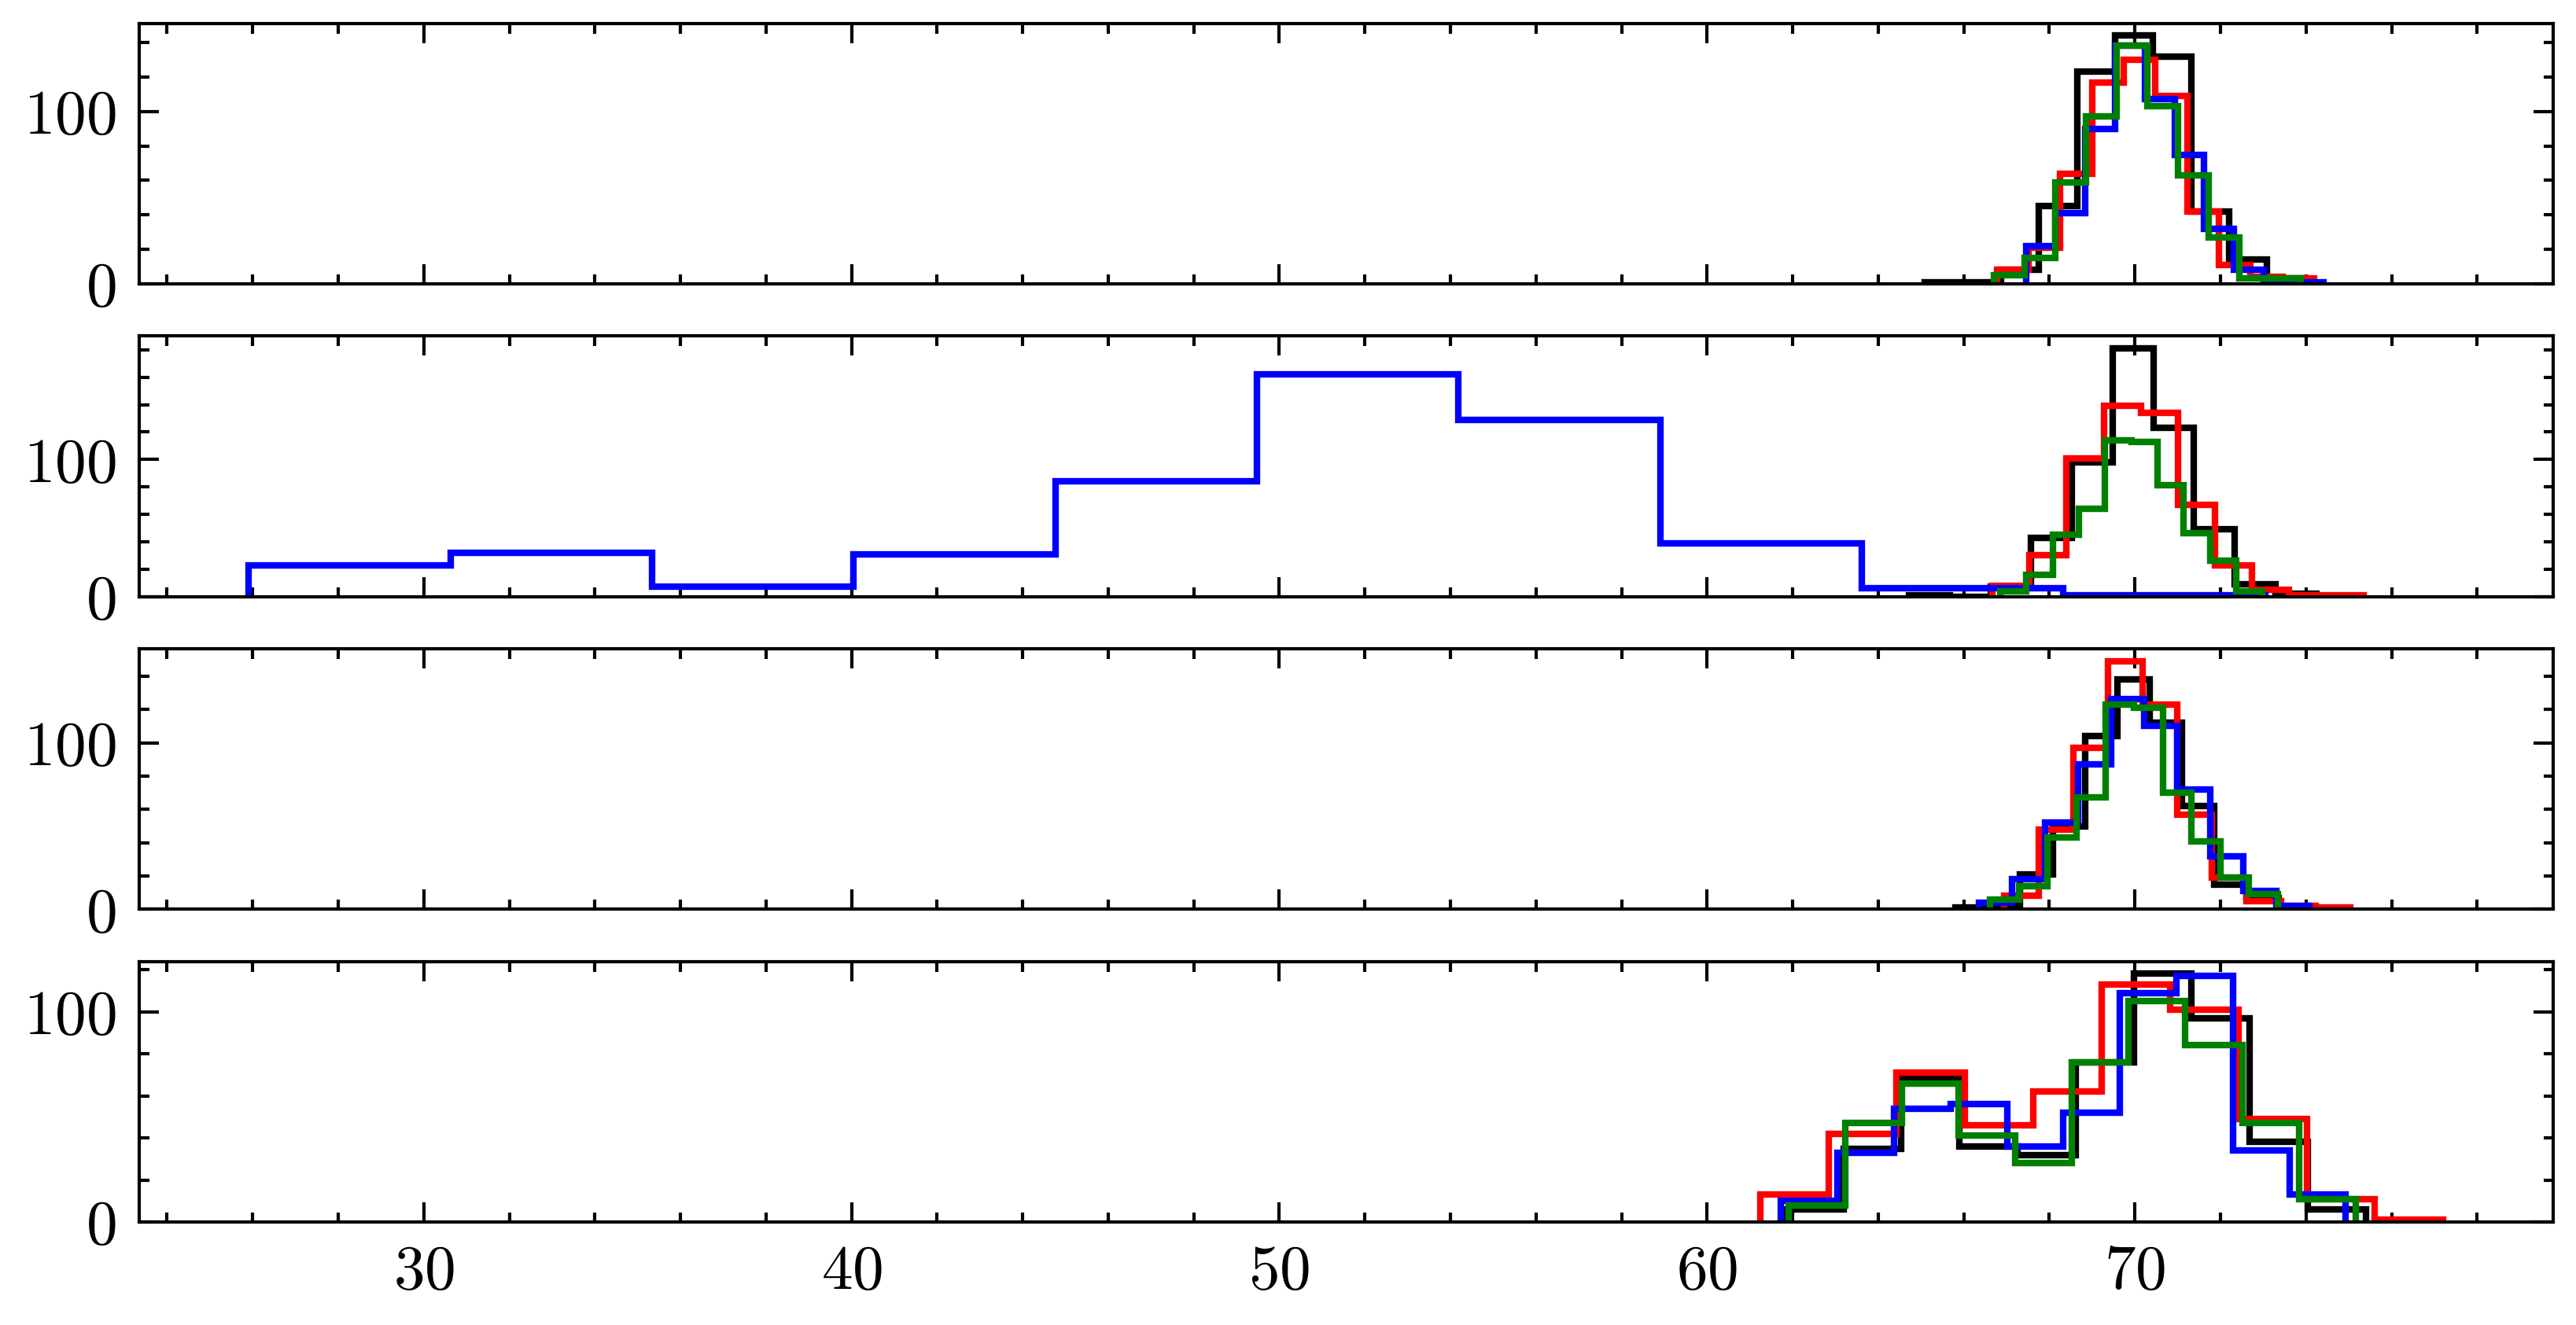

In [ ]:
# 70 Hz Rate - 2.53 scaling factor !!
do_shit('peak3.txt', Monit(2025, 2, range(21,24)))